In [ ]:
import os
from os import path
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
from sklearn.preprocessing import StandardScaler
import random
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
a = pd.read_csv ('/content/drive/MyDrive/list_attr_celeba.txt', sep="\s+")

In [ ]:

m=np.array(a)
k=0
for j in a.columns:
  count=0
  for i in range(len(m)):
    if m[i][k]==1:
      count=count+1
  if(str(j)=='filename'):
    print('Attribute'+'---------------------'+'positive samples'+ '-------------------'+'negative samples')
  else:
    print(str(j)+'---------------------------'+str(count)+ '-----------------------------'+str(202599-count))
  k=k+1

Attribute---------------------positive samples-------------------negative samples
5_o_Clock_Shadow---------------------------22516-----------------------------180083
Arched_Eyebrows---------------------------54090-----------------------------148509
Attractive---------------------------103833-----------------------------98766
Bags_Under_Eyes---------------------------41446-----------------------------161153
Bald---------------------------4547-----------------------------198052
Bangs---------------------------30709-----------------------------171890
Big_Lips---------------------------48785-----------------------------153814
Big_Nose---------------------------47516-----------------------------155083
Black_Hair---------------------------48472-----------------------------154127
Blond_Hair---------------------------29983-----------------------------172616
Blurry---------------------------10312-----------------------------192287
Brown_Hair---------------------------41572----------------------

In [ ]:
print(a)

          filename  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
0       000001.jpg                -1                1           1   
1       000002.jpg                -1               -1          -1   
2       000003.jpg                -1               -1          -1   
3       000004.jpg                -1               -1           1   
4       000005.jpg                -1                1           1   
...            ...               ...              ...         ...   
202594  202595.jpg                -1               -1           1   
202595  202596.jpg                -1               -1          -1   
202596  202597.jpg                -1               -1          -1   
202597  202598.jpg                -1                1           1   
202598  202599.jpg                -1                1           1   

        Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
0                    -1    -1     -1        -1        -1          -1  ...   
1                

In [ ]:

def dropColumns(csv_file):
  csv_file = csv_file[['filename', 'Smiling']]
  print(csv_file)
  print(csv_file.iloc[:5, :])   #First 5 Rows of the CSV File
  print("=============================")
  return csv_file

In [ ]:
a=dropColumns(a)
a=np.array(a)

          filename  Smiling
0       000001.jpg        1
1       000002.jpg        1
2       000003.jpg       -1
3       000004.jpg       -1
4       000005.jpg       -1
...            ...      ...
202594  202595.jpg       -1
202595  202596.jpg        1
202596  202597.jpg        1
202597  202598.jpg        1
202598  202599.jpg       -1

[202599 rows x 2 columns]
     filename  Smiling
0  000001.jpg        1
1  000002.jpg        1
2  000003.jpg       -1
3  000004.jpg       -1
4  000005.jpg       -1


In [ ]:
train=[]

for i in range(len(a)):
  temp=[]
  temp.append(a[i][0])
  if a[i][1]==-1 :
    temp.append(0)
  else :
    temp.append(a[i][1])
  train.append(temp)
train=pd.DataFrame(train)
train

,0,1
0,000001.jpg,1
1,000002.jpg,1
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0
...,...,...
202594,202595.jpg,0
202595,202596.jpg,1
202596,202597.jpg,1
202597,202598.jpg,1


In [ ]:
!unzip '/content/drive/MyDrive/img_align_celeba.zip'

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: img_align_celeba/197600.jpg  
  inflating: img_align_celeba/197601.jpg  
  inflating: img_align_celeba/197602.jpg  
  inflating: img_align_celeba/197603.jpg  
  inflating: img_align_celeba/197604.jpg  
  inflating: img_align_celeba/197605.jpg  
  inflating: img_align_celeba/197606.jpg  
  inflating: img_align_celeba/197607.jpg  
  inflating: img_align_celeba/197608.jpg  
  inflating: img_align_celeba/197609.jpg  
  inflating: img_align_celeba/197610.jpg  
  inflating: img_align_celeba/197611.jpg  
  inflating: img_align_celeba/197612.jpg  
  inflating: img_align_celeba/197613.jpg  
  inflating: img_align_celeba/197614.jpg  
  inflating: img_align_celeba/197615.jpg  
  inflating: img_align_celeba/197616.jpg  
  inflating: img_align_celeba/197617.jpg  
  inflating: img_align_celeba/197618.jpg  
  inflating: img_align_celeba/197619.jpg  
  inflating: img_align_celeba/197620.jpg  
  inflating: img_align_celeba/197621.jpg  
  infla

In [ ]:
TRAIN_PATH = '/content/img_align_celeba'

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data.iloc[index]

        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [ ]:
mean = [0.5,]                                             # Resize and normalization
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(40),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(40),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
        transforms.Resize(40),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(train, TRAIN_PATH, train_transform)
test_data  = Dataset(train, TRAIN_PATH, test_transform)
val_data  = Dataset(train, TRAIN_PATH, val_transform)


print("Total Samples: ",len(train_data))
len(train_data[0])

Total Samples:  202599


2

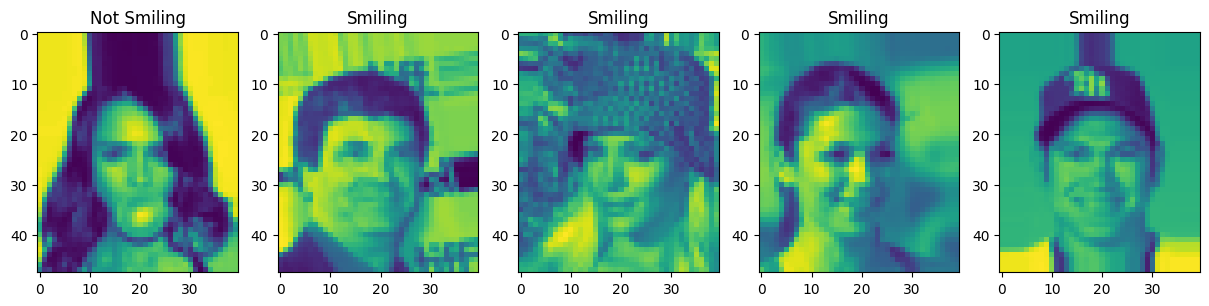

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig,ax=plt.subplots(1,5,figsize=(15,15))

for i in range(5):
  a=random.randint(1,202599)
  show_img = train_data[a][0].numpy().reshape(48,40)

  ax[i].imshow(show_img)

  if train_data[a][1]==1:
    ax[i].set_title('Smiling')
  else:
    ax[i].set_title('Not Smiling')

In [ ]:
batch_size = 100
num_iters = 1216
learning_rate = 0.005
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
test_size = 0.2

num_train = len(train_data)

indices = list(range(num_train))

np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))

train_idx, test_idx = indices[split:], indices[:split]




val_size = 0.25

num2 = len(train_idx)

indices = list(range(num2))

np.random.shuffle(indices)
split = int(np.floor(val_size * num2))
train_idx, val_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
val_sampler = SubsetRandomSampler(val_idx)


train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train samples: ",len(train_sampler))
print("Test samples: ",len(test_sampler))
print("Validation samples: ",len(val_sampler))

Train samples:  121560
Test samples:  40519
Validation samples:  40520


In [ ]:
num_epochs = num_iters / (len(train_sampler) / batch_size)
num_epochs = int(num_epochs)
num_epochs

1

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        ### 1st hidden layer: 1920 --> 500
        self.linear_1 = nn.Linear(input_size, 500)
        ### Non-linearity in 1st hidden layer
        self.layer_1 = nn.Tanh()

        ### 2nd hidden layer: 500 --> 100
        self.linear_2 = nn.Linear(500,100)
        ### Non-linearity in 2nd hidden layer
        self.layer_2 = nn.ReLU()





        ### Output layer: 100 --> 2
        self.linear_out = nn.Linear(100, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.layer_1(out)

        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.layer_2(out)



        # Linear layer (output)
        logits  = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = 48*40,
                           num_classes = 2)
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=1920, out_features=500, bias=True)
  (layer_1): Tanh()
  (linear_2): Linear(in_features=500, out_features=100, bias=True)
  (layer_2): ReLU()
  (linear_out): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
accuracy_gain = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 48*40).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images)

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 100 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in val_loader:

                images = images.view(-1, 48*40).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            accuracy_gain.append(accuracy)
            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 100. Loss: 0.4626050591468811. Accuracy: 83.11903057824725
Iteration: 200. Loss: 0.40744155645370483. Accuracy: 83.7607048545127
Iteration: 300. Loss: 0.5802562832832336. Accuracy: 84.00009871911942
Iteration: 400. Loss: 0.30479973554611206. Accuracy: 85.03171351711542
Iteration: 500. Loss: 0.3175545632839203. Accuracy: 86.1768553024507
Iteration: 600. Loss: 0.34868714213371277. Accuracy: 86.45573681482762
Iteration: 700. Loss: 0.4162445366382599. Accuracy: 85.20447197610997
Iteration: 800. Loss: 0.3440929055213928. Accuracy: 85.54258496014215
Iteration: 900. Loss: 0.27527815103530884. Accuracy: 82.80066141810015
Iteration: 1000. Loss: 0.3539154827594757. Accuracy: 86.46314074878453
Iteration: 1100. Loss: 0.31077855825424194. Accuracy: 86.5766677361238
Iteration: 1200. Loss: 0.3211192190647125. Accuracy: 85.4512697746736


[0.4626050591468811, 0.40744155645370483, 0.5802562832832336, 0.30479973554611206, 0.3175545632839203, 0.34868714213371277, 0.4162445366382599, 0.3440929055213928, 0.27527815103530884, 0.3539154827594757, 0.31077855825424194, 0.3211192190647125]


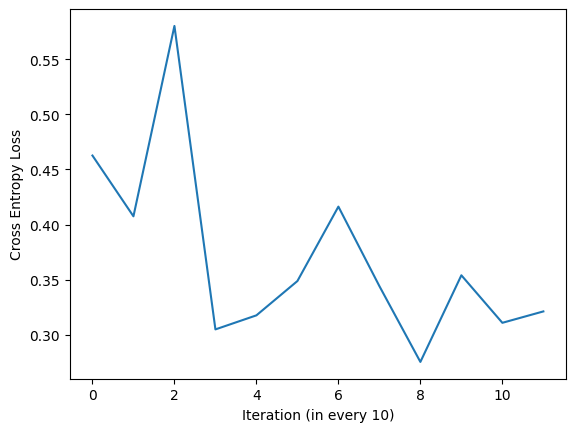

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 10)')
plt.show()

[83.11903057824725, 83.7607048545127, 84.00009871911942, 85.03171351711542, 86.1768553024507, 86.45573681482762, 85.20447197610997, 85.54258496014215, 82.80066141810015, 86.46314074878453, 86.5766677361238, 85.4512697746736]


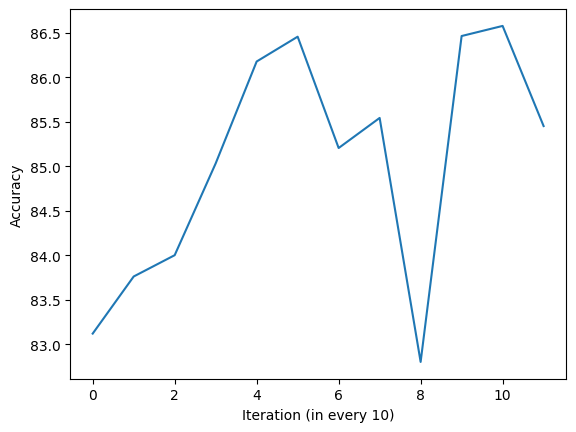

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (accuracy_gain)
plt.plot(accuracy_gain)
plt.ylabel('Accuracy')
plt.xlabel('Iteration (in every 10)')
plt.show()


In [ ]:
save_model = True
root_path='/content/drive/MyDrive/savedmodels/'
if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'sc1.pkl')

In [ ]:

load_model = True
root_path='/content/drive/MyDrive/savedmodels/'
if load_model is True:
    model.load_state_dict(torch.load(root_path + 'sc1.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


In [ ]:
def F_score(logit, label, threshold=0.5):
    prob = torch.sigmoid(logit)
    prob = prob > threshold
    label = label > threshold
    TP = (prob & label).sum().float()
    TN = ((~prob) & (~label)).sum().float()
    FP = (prob & (~label)).sum().float()
    FN = ((~prob) & label).sum().float()
    return TP,TN,FP,FN

In [ ]:
TP=0
TN=0
FP=0
FN=0

for images, labels in test_loader:

                images = images.view(-1, 48*40).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                T_P,T_N,F_P,F_N = F_score(predicted.cpu().squeeze(), labels.cpu().float())
                T_P=T_P.cpu().numpy()
                T_N=T_N.cpu().numpy()
                F_P=F_P.cpu().numpy()
                F_N=F_N.cpu().numpy()
                TP+=T_P
                TN+=T_N
                FP+=F_P
                FN+=F_N

In [ ]:
TN, TP, FN, FP, TP+TN+FP+FN

(18235.0, 16430.0, 3099.0, 2755.0, 40519.0)

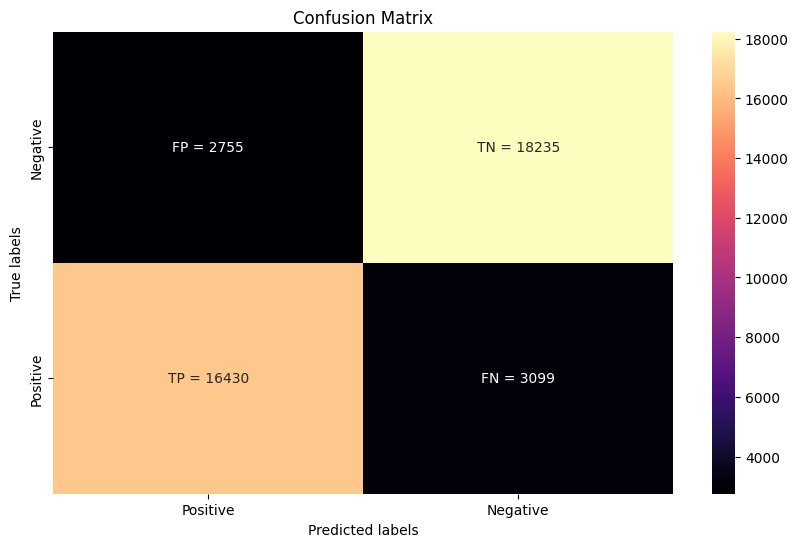

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
labels= [['FP = '+str(int(FP)),'TN = '+str(int(TN))],['TP = '+str(int(TP)),'FN = '+str(int(FN))]]
values = [[FP,TN],[TP,FN]]
values=[[int(i) for i in x] for x in values]

plt.figure(figsize=(10,6))

ax= plt.subplot()

sns.heatmap(values, annot=labels, ax = ax,fmt='',cmap="magma");

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Positive','Negative']); ax.yaxis.set_ticklabels(['Negative','Positive']);

In [ ]:
accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
precision = (TP / (TP + FP ))*100
recall = (TP / (TP + FN ))*100
F1 = (2 * precision * recall / ( precision + recall ))

accuracy,precision,recall,F1

(85.5524568720847, 85.63982277821215, 84.13129192482974, 84.87885519450327)

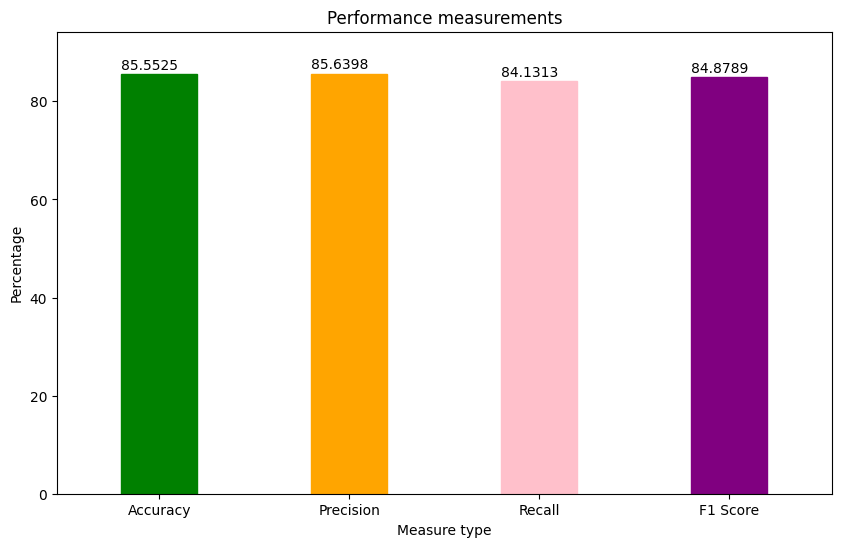

In [ ]:
data = {'Accuracy':accuracy, 'Precision':precision, 'Recall':recall,
        'F1 Score':F1}
figlabel = list(data.keys())
figvalues = list(data.values())

fig = plt.figure(figsize = (10, 6))

# creating the bar plot
barlist=plt.bar(figlabel, figvalues,width = 0.4)
barlist[0].set_color('green')
barlist[1].set_color('orange')
barlist[2].set_color('pink')
barlist[3].set_color('purple')
for bar in (barlist):
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 1, round(yval,4))
plt.xlabel("Measure type")
plt.ylabel("Percentage")
plt.title("Performance measurements")
plt.margins(0.1)
plt.show()

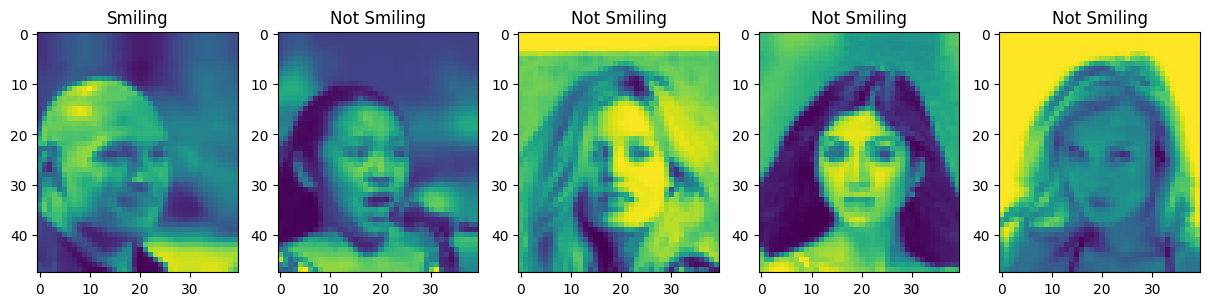

In [ ]:
for images, labels in test_loader:
    break

fig, ax = plt.subplots(1, 5,figsize=(15,15))
for i in range(5):
    ax[i].imshow(images[i].view(48, 40))
    if labels[i]==1:
      ax[i].set_title('Smiling')
    else:
      ax[i].set_title('Not Smiling')

plt.show()